# Predicting Diamond Prices

### Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline

## Our first Machine Learning model

In [23]:
DATA_DIR = '../data'
FILE_NAME = 'diamonds.csv'
data_path = os.path.join(DATA_DIR, FILE_NAME)
diamonds = pd.read_csv(data_path)
## Preparation done from Chapter 2
diamonds = diamonds.loc[(diamonds['x']>0) | (diamonds['y']>0)]
diamonds.loc[11182, 'x'] = diamonds['x'].median()
diamonds.loc[11182, 'z'] = diamonds['z'].median()
diamonds = diamonds.loc[~((diamonds['y'] > 30) | (diamonds['z'] > 30))]
diamonds = pd.concat([diamonds, pd.get_dummies(diamonds['cut'], prefix='cut', drop_first=True)], axis=1)
diamonds = pd.concat([diamonds, pd.get_dummies(diamonds['color'], prefix='color', drop_first=True)], axis=1)
diamonds = pd.concat([diamonds, pd.get_dummies(diamonds['clarity'], prefix='clarity', drop_first=True)], axis=1)

In [24]:
w = np.mean(diamonds['price']/diamonds['carat'])
w

4008.0243030179727

In [25]:
def first_ml_model(carat):
    return 4008.024 * carat

In [26]:
carat_values = np.arange(0.5, 5.5, 0.5)
preds = first_ml_model(carat_values)
pd.DataFrame({"Carat": carat_values, "Predicted price":preds})

,Carat,Predicted price
0,0.5,2004.012
1,1.0,4008.024
2,1.5,6012.036
3,2.0,8016.048
4,2.5,10020.060
5,3.0,12024.072
6,3.5,14028.084
7,4.0,16032.096
8,4.5,18036.108
9,5.0,20040.120


## Practical Considerations Before Modelling

### Train-test split

In [28]:
X = diamonds.drop(['cut','color','clarity','price'], axis=1)
y = diamonds['price']

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=123)

### Dimensionality reduction using PCA  

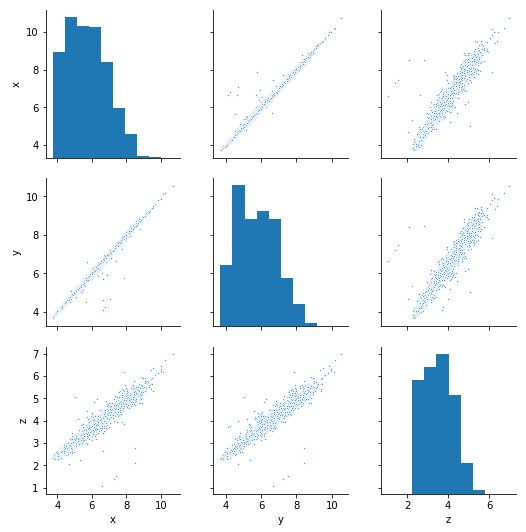

In [29]:
sns.pairplot(X_train[['x','y','z']], plot_kws={"s": 3});

In [32]:
# 1. Import the class you will use
from sklearn.decomposition import PCA
# 2. Create an instance of the class
pca = PCA(n_components=3, random_state=123)
# 3. Use the fit method of the instance
pca.fit(X_train[['x','y','z']])
# 4. Use the transform method to perform the transformation
princ_comp = pca.transform(X_train[['x','y','z']])

In [33]:
pca.explained_variance_ratio_.round(3)

array([0.997, 0.002, 0.001])

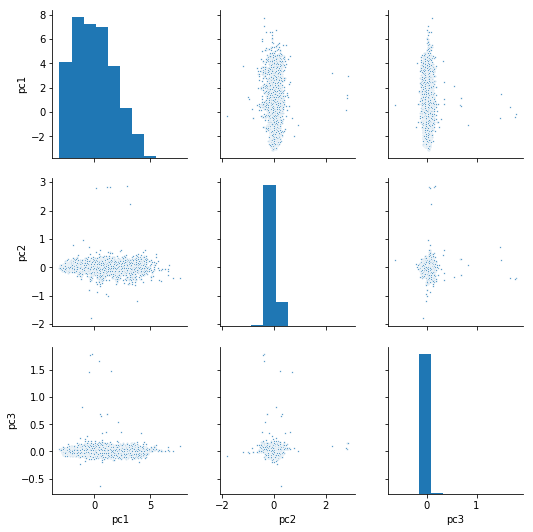

In [34]:
princ_comp = pd.DataFrame(data=princ_comp, columns=['pc1', 'pc2', 'pc3'])
sns.pairplot(princ_comp, plot_kws={"s": 3});

In [36]:
princ_comp.corr().round(4)

,pc1,pc2,pc3
pc1,1.0,0.0,0.0
pc2,0.0,1.0,0.0
pc3,0.0,0.0,1.0


In [37]:
## Get only the first principal component
pca = PCA(n_components=1, random_state=123)
## Train the pca transformer
pca.fit(X_train[['x','y','z']])
# Add the new feature to the dataset
X_train['dim_index'] = pca.transform(X_train[['x','y','z']]).flatten()
# Drop x, y, and z
X_train.drop(['x','y','z'], axis=1, inplace=True)

### Standarization: centering and scaling 

In [40]:
numerical_features = ['carat', 'depth', 'table', 'dim_index']

In [41]:
# 1. Import the class you will use
from sklearn.preprocessing import StandardScaler
# 2. Create an instance of the class
scaler = StandardScaler()
# 3. Use the fit method of the instance
scaler.fit(X_train[numerical_features])
# 4. Use the transform method to perform the transformation
X_train.loc[:, numerical_features] = scaler.transform(X_train[numerical_features])

In [42]:
X_train[numerical_features].head()

,carat,depth,table,dim_index
30066,-0.840293,1.429309,-0.205642,-0.918724
17608,0.677534,0.383359,-2.001069,0.848719
42508,-0.629484,0.034709,-0.205642,-0.568908
22842,0.719696,-0.662591,0.243215,0.908842
25957,2.553737,-1.987460,2.487499,2.147581


In [44]:
X_train[numerical_features].describe().round(4)

,carat,depth,table,dim_index
count,48537.0000,48537.0000,48537.0000,48537.0000
mean,-0.0000,-0.0000,-0.0000,0.0000
std,1.0000,1.0000,1.0000,1.0000
min,-1.2619,-13.0745,-6.4896,-1.8151
25%,-0.8403,-0.5231,-0.6545,-0.9077
50%,-0.2079,0.0347,-0.2056,-0.0236
75%,0.5089,0.5228,0.6921,0.7115
max,8.8780,12.0283,9.6692,4.4957


## Multiple Linear Regression

In [45]:
# 1. Import the Estimator class you will use
from sklearn.linear_model import LinearRegression
# 2. Create an instance of the class
ml_reg = LinearRegression()
# 3. Use the fit method of the instance
ml_reg.fit(X_train, y_train)
# 4. Use the predict method to get the predictions
y_pred_ml_reg = ml_reg.predict(X_train)

In [46]:
pd.Series(ml_reg.coef_, index=X_train.columns).sort_values(ascending=False).round(2)

carat            5422.04
clarity_IF       5384.93
clarity_VVS1     5040.24
clarity_VVS2     4993.61
clarity_VS1      4616.93
clarity_VS2      4303.06
clarity_SI1      3704.82
clarity_SI2      2740.18
cut_Ideal         856.23
cut_Premium       756.77
cut_Very Good     756.17
cut_Good          609.70
table             -59.04
depth             -80.63
color_E          -217.07
color_F          -276.78
color_G          -489.66
color_H          -991.01
dim_index       -1235.23
color_I         -1480.56
color_J         -2384.35
dtype: float64

In [47]:
# training the model without carat
ml_reg.fit(X_train.drop('carat', axis=1), y_train)
pd.Series(ml_reg.coef_, index=X_train.drop('carat', axis=1).columns).sort_values(ascending=False).round(2)

clarity_IF       5148.67
clarity_VVS1     4790.55
clarity_VVS2     4598.87
dim_index        4037.32
clarity_VS1      4006.20
clarity_VS2      3711.01
clarity_SI1      2975.99
clarity_SI2      2210.70
cut_Premium       934.69
cut_Ideal         923.11
cut_Very Good     811.81
cut_Good          607.89
depth             136.90
table              -6.19
color_E          -212.55
color_F          -361.49
color_G          -503.53
color_H          -814.98
color_I         -1111.87
color_J         -1876.45
dtype: float64

In [48]:
# re-training the model with all features again.
ml_reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [49]:
from sklearn.metrics import mean_squared_error
mse_ml_reg = mean_squared_error(y_true=y_train, y_pred=y_pred_ml_reg)
print('{:0.2f}M'.format(mse_ml_reg/1e6))

1.28M


In [50]:
y_pred_null_model = np.full(y_train.shape, y_train.mean())
mse_null_model = mean_squared_error(y_true=y_train, y_pred=y_pred_null_model)
print('{:0.2f}M'.format(mse_null_model/1e6))

15.92M


## Lasso regression

In [51]:
# 1. Import the Estimator class you will use
from sklearn.linear_model import Lasso
# 2. Create an instance of the class
lasso = Lasso(alpha=10)
# 3. Use the fit method of the instance
lasso.fit(X_train, y_train)
# 4. Use the predict method to get the predictions
y_pred_lasso = lasso.predict(X_train)

## MSE calculation
mse_lasso = mean_squared_error(y_true=y_train, y_pred=y_pred_lasso)
print('{:0.2f}M'.format(mse_lasso/1e6))

1.52M


In [52]:
pd.Series(lasso.coef_, index=X_train.columns).sort_values(ascending=False).round(2)

carat            4766.29
clarity_IF       1348.44
clarity_VVS2     1213.08
clarity_VVS1     1194.84
clarity_VS1       860.32
clarity_VS2       616.93
cut_Ideal         169.10
cut_Very Good      89.01
cut_Premium        55.05
clarity_SI1        33.97
cut_Good           -0.00
color_F            -0.00
color_E             0.00
table            -103.99
color_G          -124.79
depth            -145.90
color_H          -609.87
dim_index        -708.54
clarity_SI2      -768.25
color_I         -1001.55
color_J         -1780.44
dtype: float64

### KNN Regression

In [53]:
# 1. Import the Estimator class you will use
from sklearn.neighbors import KNeighborsRegressor
# 2. Create an instance of the class
knn = KNeighborsRegressor(n_neighbors=12)
# 3. Use the fit method of the instance
knn.fit(X_train, y_train)
# 4. Use the predict method to get the predictions
y_pred_knn = knn.predict(X_train)

In [54]:
mse_knn = mean_squared_error(y_true=y_train, y_pred=y_pred_knn)
print('{:0.2f}M'.format(mse_knn/1e6))

0.67M


## Evaluating in the testing dataset

### KNN with perfect performance

In [55]:
perfect_knn = KNeighborsRegressor(n_neighbors=1)
perfect_knn.fit(X_train, y_train)
mean_squared_error(y_true=y_train, y_pred=perfect_knn.predict(X_train))

148.9197519418176

### Applying the tranformations

In [56]:
## Replacing x, y, z with dim_index using PCA: notice we are not training, just transforming
X_test['dim_index'] = pca.transform(X_test[['x','y','z']]).flatten()

# Remove x, y and z from the dataset
X_test.drop(['x','y','z'], axis=1, inplace=True)

## Scale our numerical features so they have zero mean and a variance of one
X_test.loc[:, numerical_features] = scaler.transform(X_test[numerical_features])

In [57]:
mse = pd.DataFrame(columns=['train', 'test'], index=['MLR','Lasso','KNN'])
model_dict = {'MLR': ml_reg, 'Lasso': lasso, 'KNN': knn}
for name, model in model_dict.items():
    mse.loc[name, 'train'] = mean_squared_error(y_true=y_train, y_pred=model.predict(X_train))/1e6 
    mse.loc[name, 'test'] = mean_squared_error(y_true=y_test, y_pred=model.predict(X_test))/1e6
    

In [58]:
mse

,train,test
MLR,1.28101,1.20721
Lasso,1.52062,1.40893
KNN,0.670249,0.780698


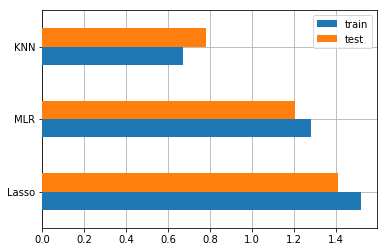

In [59]:
fig, ax = plt.subplots()
mse.sort_values(by='test', ascending=False).plot(kind='barh', ax=ax, zorder=3)
ax.grid(zorder=0)

In [60]:
demo_pred = X_test.iloc[:10].copy()
pred_dict = {'y_true':y_test[:10]}
for name, model in model_dict.items():
    pred_dict['pred_'+name] = model.predict(demo_pred).round(1)

pd.DataFrame(pred_dict)

,y_true,pred_MLR,pred_Lasso,pred_KNN
8549,4434,4638.0,4993.4,4172.9
27123,17313,15503.2,14918.2,14771.3
40907,1179,1603.1,1611.9,1092.5
1375,2966,3063.0,3299.2,2915.8
41673,1240,1859.6,1567.7,978.0
35461,901,1700.1,1329.1,1158.1
30655,736,1086.4,689.6,754.6
10271,4752,6010.9,6042.6,4970.2
28928,684,904.1,762.3,753.5
26351,645,704.7,651.4,722.9
